# Model Agnostic Methods

Sometimes, the interpretable models just don't cut it and we need to resort a more complex model. This is absolutely normal - complex problems often require complex solutions. However, we still need to be able to verify and validate the model. We need to be able to understand how it works and how it can be manipulated or misused.

This is where model agnostic methods come into play. In this case we can only manipulate the inputs and observe the change in outputs. 

This notebook will cover three methods:
1. Partial Dependence Plots
2. Permutation Feature Importance
3. Surrogate methods

Again, please reference https://christophm.github.io/interpretable-ml-book/agnostic.html for a lot more detail and more sophisticated methods.

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set('notebook')
sns.set_style('white')

In [69]:
data = pd.read_csv('../data/deputat_daily_features.csv').dropna()
data.head()

,Unnamed: 0,deputat,party,present,date,Year,Month,Week,Day,Dayofweek,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,present_last_ass,present_last_5ass
5,5,АДЛЕН ШУКРИ ШЕВКЕД,ДПС,False,2019-01-24,2019,1,4,24,3,False,False,False,False,False,False,0.0,0.6
6,6,АДЛЕН ШУКРИ ШЕВКЕД,ДПС,False,2019-01-25,2019,1,4,25,4,False,False,False,False,False,False,0.0,0.4
7,7,АДЛЕН ШУКРИ ШЕВКЕД,ДПС,False,2019-01-30,2019,1,5,30,2,False,False,False,False,False,False,0.0,0.4
8,8,АДЛЕН ШУКРИ ШЕВКЕД,ДПС,False,2019-01-31,2019,1,5,31,3,True,False,False,False,False,False,0.0,0.2
9,9,АДЛЕН ШУКРИ ШЕВКЕД,ДПС,False,2019-02-01,2019,2,5,1,4,False,True,False,False,False,False,0.0,0.0


In [70]:
numerical_features = ['present_last_ass', 'present_last_5ass']
categorical_features = ['party']

def prepare_features_df(data):
    features_df = data[numerical_features].copy()

    for cat_feat in categorical_features:
        dummies = pd.get_dummies(data[cat_feat], prefix=cat_feat)
        dummies = dummies.drop(columns=dummies.columns[:1])
        features_df = pd.concat([features_df, dummies],axis=1)
    features_df['bias'] = 1
    return features_df


    
features_df = prepare_features_df(data)

## Train the black box model

To test the methods, we will be using a deep neural network - a 3-layer perceptron. We're using it for illustrative purposes, so we don't need to go overly complex.


In [71]:
from sklearn.neural_network import MLPClassifier

In [91]:
# define the model
model = MLPClassifier(hidden_layer_sizes=(50, 20, 10))

In [92]:
# fit the model
model.fit(features_df.values, data['present'])

MLPClassifier(hidden_layer_sizes=(50, 20, 10))

In [93]:
# score the model
model.score(features_df.values, data['present'])

0.7480953199289683

In [75]:
predictions = model.predict_proba(features_df.values)[:,1]

## Partial Dependence Plot

The Partial Dependence Plot(PDP) is quite an intuitive method. To reason about how the predictions change with a given feature, we measure the mean prediction for a dataset where the feature is set to a particular value across a range of values.

For example, we will measure how the `present_last_5ass` feature impacts the prediction. To do so, we define a range of levels `[0, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8, 0.9, 1.]`. For each levels we set the feature value to be equal to the level for each example in the dataset and run inference. The PDP is then a plot of the mean predictions for each of the levels.

In [76]:
from sklearn.inspection import partial_dependence,plot_partial_dependence

In [77]:
# mean prediction
before = model.predict_proba(features_df.values).mean()
afters = []

for level in [0, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8, 0.9, 1.]:    
    modified_data = data.copy()
    
    #set the feature to the current level
    modified_data['present_last_5ass'] = level
    partial_dep_df = prepare_features_df(modified_data)
    after = model.predict_proba(partial_dep_df.values)[:,1].mean()
    afters.append(after)
    
before, afters

(0.5,
 [0.18679544587871005,
  0.26486353586461825,
  0.34585288455506386,
  0.4051804997578573,
  0.46636769107457116,
  0.5245960925808307,
  0.5831717387217558,
  0.6365443732961801,
  0.6870489262685338,
  0.7326427494939599,
  0.7728624155116625])

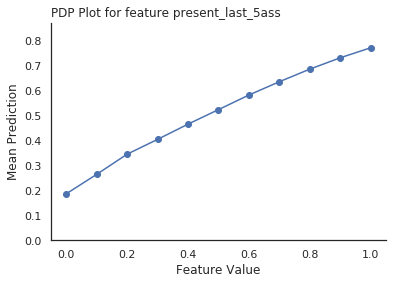

In [84]:
fig, ax = plt.subplots()
sns.despine(fig)
ax.plot([0, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8, 0.9, 1.], afters, 'bo-')

ax.set_ylabel('Mean Prediction')
ax.set_xlabel('Feature Value')
ax.set_title("PDP Plot for feature present_last_5ass", loc='left')

ax.set_ylim((0, max(afters) + 0.1));

party_ДПС      0.562296
party_НЕЗ      0.562296
base           0.622902
party_ГЕРБ     0.622902
party_ПГБСП    0.622902
party_ОП       0.648021
dtype: float64

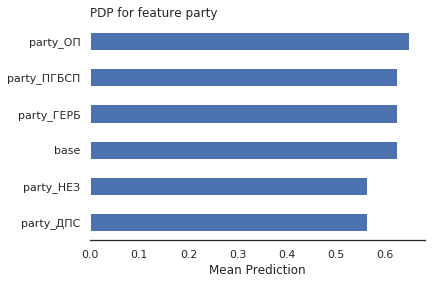

In [94]:
def pdp_categorical(model, features, feature_prefix):
    feature_columns = [x for x in features.columns if x.startswith(feature_prefix)]
    pdp_features = features.copy()
    pdp_features[feature_columns] = 0
    base_preds = model.predict(pdp_features)
    scores = {
        'base': base_preds.mean()
    }
    for feature_col in feature_columns:
        pdp_features[feature_col] = 1
        scores[feature_col] = model.predict(pdp_features).mean()
        pdp_features[feature_col] = 0
    return pd.Series(scores).sort_values()

scores = pdp_categorical(model, features_df, 'party_')
display(scores)

fig, ax = plt.subplots()
sns.despine(fig, left=True)
ax.set_title('PDP for feature party', loc='left')
ax.set_xlabel('Mean Prediction')
pd.Series(scores).sort_values().plot(kind='barh', ax= ax);


## Permutation Feature Importance

With permutation feature importance, we reason how erasing the information from a given feature changes the quality of the output.

The procedure for a feature of interest `x` is as follows:

1. Randomly shuffle the values of `x` for the entire dataset
2. Run inference
3. Compute the value of the validation function(e.g. accuracy)

If the accuracy of the predictions from the shuffled data has dropped, then the feature is important. If it stays the same, then the model does not pay attention to it.

In [17]:
import numpy as np

In [41]:

def get_perm_importance(features_df, feat):
    orig_score = model.score(features_df, data['present'])
    shuffled_scores = []

    for _ in range(5):
        df = features_df.copy()
        df[feat] = np.random.permutation(df[feat])
        shuffled_score = model.score(df, data['present'])
        shuffled_scores.append(shuffled_score)
    return orig_score - np.mean(shuffled_scores)

get_perm_importance(features_df, 'present_last_5ass')

0.1980466288594832

## Global Surrogate

The concept behind the global surrogate model is quite simple: Train an interpretable model that can reproduce the outputs of the black box model.

Note in this case, that we are trying to interpret the model. The resulting interpretation explains the model, not the data.

In [43]:
from statsmodels import api

In [96]:
# NOTE: we are fitting against the predictions and not the actual values
lin_reg = api.OLS(predictions, features_df)

In [97]:
results = lin_reg.fit()

In [98]:
from interpretable_models import weight_plot, effect_plot

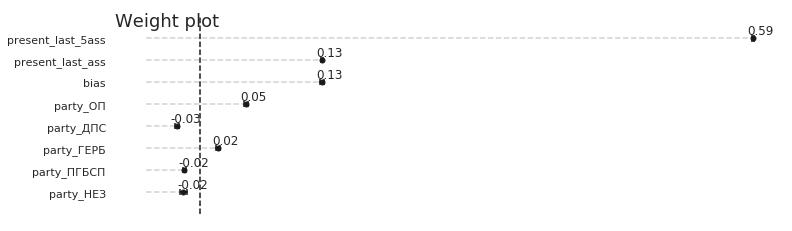

In [99]:
weight_plot(results)

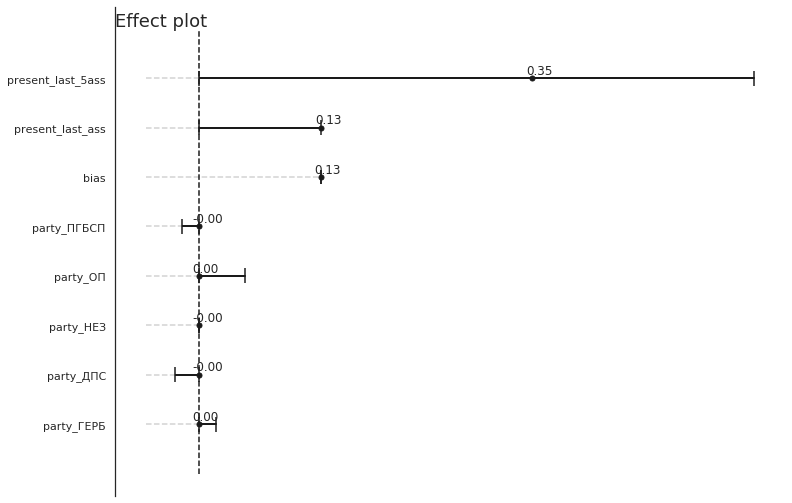

In [100]:
effect_plot(results, features_df);

## LIME: Local interpretable model-agnostic explanations

LIME is essentially a surrogate method. The difference is that instead of trying to approximate the model in the global setting, we are trying to understand how the model behaves for a subspace of the parameter space.

The assumption is that while the model might be super complex in the global level, we should be able to reason about how the predictions change around a given point of interest.

The procedure is as follows:
1. Pick a point or a collection of points of interest
2. Generate/sample artificial points in the neighbourhood of the point of interest
3. Train a surrogate interpretable model on the generated points, weighted by proximity to the point of interest
4. Inspect the surrogate model

![](https://christophm.github.io/interpretable-ml-book/images/lime-fitting-1.png)
>FIGURE 5.33 of Interpretable Machine Learning: LIME algorithm for tabular data. A) Random forest predictions given features x1 and x2. Predicted classes: 1 (dark) or 0 (light). B) Instance of interest (big dot) and data sampled from a normal distribution (small dots). C) Assign higher weight to points near the instance of interest. D) Signs of the grid show the classifications of the locally learned model from the weighted samples. The white line marks the decision boundary (P(class=1) = 0.5).